# Tutorial 1: Lennard-Jones Liquid

## Table of Contents
1. [Introduction](#Introduction)
2. [Background](#Background)
3. [The Lennard-Jones Potential](#The-Lennard-Jones-Potential)
4. [Units](#Units)
5. [Python versions](#Python-versions)
6. [First steps](#First-steps)
7. [Overview of a simulation script](#Overview-of-a-simulation-script)
    1. [System setup](#System-setup)
    2. [Choosing the thermodynamic ensemble, thermostat](#Choosing-the-thermodynamic-ensemble,-thermostat)
    3. [Placing and accessing particles](#Placing-and-accessing-particles)
    4. [Setting up non-bonded interactions](#Setting-up-non-bonded-interactions)
    5. [Warmup](#Warmup)
    6. [Integrating equations of motion and taking measurements](#Integrating-equations-of-motion-and-taking-measurements)
    7. [Simple Error Estimation on Time Series Data](#Simple-Error-Estimation-on-Time-Series-Data)
8. [Exercises](#Exercises)
    1. [Binary Lennard-Jones Liquid](#Binary-Lennard-Jones-Liquid)
9. [References](#References)
    

## Introduction

Welcome to the basic ESPResSo tutorial!

In this tutorial, you will learn, how to use the ESPResSo package for your 
research. We will cover the basics of ESPResSo, i.e., how to set up and modify a physical system, how to run a simulation, and how to load, save and analyze the produced simulation data.

More advanced features and algorithms available in the ESPResSo package are 
described in additional tutorials.

## Background

Today's research on Soft Condensed Matter has brought the needs for having a flexible, extensible, reliable, and efficient (parallel) molecular simulation package. For this reason ESPResSo (Extensible Simulation Package for Research on Soft matter) [1] has been developed at Max Planck Institute for Polymer Research, Mainz, and Institute for Computational Physics at the University of Stuttgart in  the group of Prof. Dr. Christian Holm [2,3]. The Espresso package is probably the most flexible and extensible simulation package in the market. It is specially developed for coarse-grained molecular dynamics (MD) simulation of polyelectrolytes but is not necessarily limited to this. For example, it could also be used to simulate granular media. ESPResSo has been nominated for the Heinz-Billing-Preis for Scientific Computing in 2003 [4].

## The Lennard-Jones Potential

A pair  of  neutral  atoms  or  molecules  is  subject  to  two  distinct  forces  in  the  limit  of large separation and small separation:  an attractive force at long ranges (van der Waals force, or dispersion force) and a repulsive force at short ranges (the result of overlapping electron  orbitals,  referred  to  as  Pauli  repulsion  from  Pauli  exclusion principle). The Lennard-Jones potential (also  referred  to  as  the  L-J potential, 6-12 potential  or, less commonly, 12-6 potential) is a simple mathematical model that represents this behavior. It  was  proposed  in  1924  by  John  Lennard-Jones. The  L-J  potential  is  of  the  form $V(r) = 4\epsilon \left[ \left( \dfrac{\sigma}{r} \right)^{12} - \left( \dfrac{\sigma}{r} \right)^{6} \right]$ where $\epsilon$ is the depth of the potential well and $\sigma$ is the (finite) distance at which the inter-particle potential is zero and $r$ is the distance between the particles. The $\left(\frac{1}{r}\right)^{12}$ term describes repulsion and the $(\frac{1}{r})^{6}$  term describes attraction. The Lennard-Jones potential is an
approximation. The form of the repulsion term has no theoretical justification; the repulsion force should depend exponentially on the distance, but the repulsion term of the L-J formula is more convenient due to the ease and efficiency of computing $r^{12}$ as the square of $r^6$.

In practice, the L-J potential is cutoff beyond a specified distance $r_{c}$ and the potential at the cutoff distance is zero.

<figure>
<img src='figures/lennard-jones-potential.png' alt='missing' style='width: 600px;'/>
<center>
<figcaption> Figure 1: Lennard-Jones potential
</figure>

## Units

Novice users must understand that Espresso has no fixed unit system. The unit 
system is set by the user. Conventionally, reduced units are employed, in other 
words LJ units.

## Python versions

Espresso can be used both, with python 2 and python 3. In these tutorials, we use python 3 print syntax. If you are on python 2, issue the following command to activate it:

In [1]:
from __future__ import print_function

## First steps

What is ESPResSo? It is an extensible, efficient Molecular Dynamics package specially powerful on simulating charged systems. In depth information about the package can be found in the relevant sources [1,4,2,3].

ESPResSo consists of two components. The simulation engine is written in C and C++ for the sake of computational efficiency. The steering or control
level is interfaced to the kernel via an interpreter of the Python scripting languages.

The kernel performs all computationally demanding tasks. Before all, integration of Newton's equations of motion, including calculation of energies and forces. It also takes care of internal organization of data, storing the data about particles, communication between different processors or cells of the cell-system.

The scripting interface (Python) is used to setup the system (particles, boundary conditions, interactions etc.), control the simulation, run analysis, and store and load results. The user has at hand the full reliability and functionality of the scripting language. For instance, it is possible to use the SciPy package for analysis and PyPlot for plotting.
With a certain overhead in efficiency, it can also be bused to reject/accept new configurations in combined MD/MC schemes. In principle, any parameter which is accessible from the scripting level can be changed at any moment of runtime. In this way methods like thermodynamic integration become readily accessible.

_Note: This tutorial assumes that you already have a working ESPResSo
installation on your system. If this is not the case, please consult the first chapters of the user's guide for installation instructions._

Python simulation scripts can be run conveniently:

In [2]:
import espressomd
print(espressomd.features())
required_features = ["LENNARD_JONES"]
espressomd.assert_features(required_features)

['CUDA', 'ENGINE', 'EXTERNAL_FORCES', 'FFTW', 'GSL', 'H5MD', 'LATTICE', 'LB', 'LB_BOUNDARIES', 'LENNARD_JONES', 'MASS', 'ROTATION', 'ROTATIONAL_INERTIA']


## Overview of a simulation script

Typically, a simulation script consists of the following parts

* System setup (box geometry, thermodynamic ensemble, integrator parameters)
* Placing the particles
* Setup of interactions between particles
* Warm up (bringing the system into a state suitable for measurements)
* Integration loop (propagate the system in time and record measurements)

### System setup

The functionality of ESPResSo for python is provided via a python module called <tt>espressomd</tt>. At the beginning of the simulation script, it has to be imported.

In [3]:
# Importing other relevant python modules
import numpy as np
# System parameters
n_part = 50
density = 0.1442

box_l=np.power(n_part/density, 1.0/3.0)*np.ones(3)

The next step would be to create an instance of the System class and to seed espresso. This instance is used as a handle to the simulation system. At any time, only one instance of the System class can exist.

In [4]:
system = espressomd.System(box_l=box_l)
system.seed = 42

It can be used to manipulate the crucial system parameters like the time step and the size of the simulation box (<tt>time_step</tt>, and <tt>box_l</tt>).

In [5]:
skin = 0.4
time_step = 0.01
eq_tstep = 0.001
temperature = 0.728

system.time_step = time_step

### Choosing the thermodynamic ensemble, thermostat

Simulations can be carried out in different thermodynamic ensembles such as NVE (particle Number, Volume, Energy), NVT (particle Number, Volume, Temperature) or NPT-isotropic (particle Number, Pressure, Temperature).

The NVE ensemble is simulated without a thermostat. A previously enabled thermostat can be swtiched off as follows:

In [6]:
system.thermostat.turn_off()

True

The NVT and NPT ensembles require a thermostat. In this tutorial, we use the Langevin thermostat.

In ESPResSo, the thermostat is set as follows:

In [7]:
system.thermostat.set_langevin(kT=temperature, gamma=1.0)

Use a Langevin thermostat (NVT or NPT ensemble) with temperature set to 1.0 and damping coefficient to 0.5.  Alternatively, the thermostat can be turned off using

### Placing and accessing particles

Particles in the simulation can be added and accessed via the <tt>part</tt> property of the System class. Individual  particles  are  referred  to  by  an  integer  id, e.g., <tt>system.part[0]</tt>. If <tt>id</tt> is unspecified, an unused particle id is automatically assigned. It  is  also possible to use common python iterators and slicing operations to add or access several particles at once.

Particles can be grouped into several types, so that, e.g., a binary fluid can be simulated. Particle types are identified by integer ids, which are set via the particles' <tt>type</tt> attribute. If it is not specified, zero is implied.

In [8]:
# Add particles to the simulation box at random positions
for i in range(n_part):
    system.part.add(type=0, pos=np.random.random(3) * system.box_l)
    
# Acess position of a single particle
print(system.part[0].pos)

# Iterate over the first five particles for the purpose of demonstration.
# For accessing all particles, do not splice system.part
for p in system.part[:5]:
    print(p.pos)
    print(p.v)
    
# Obtain all particle positions
cur_pos = system.part[:].pos

[ 6.76358603  0.51870904  1.26777052]
[ 6.76358603  0.51870904  1.26777052]
[ 0.  0.  0.]
[ 0.57486243  2.59328685  2.61196809]
[ 0.  0.  0.]
[ 2.68115615  3.74700705  6.64114197]
[ 0.  0.  0.]
[ 1.41305622  5.82065558  5.91314661]
[ 0.  0.  0.]
[ 5.92827533  1.74548108  1.3299081 ]
[ 0.  0.  0.]


Many objects in ESPResSo have a string representation, and thus can be displayed via python's <tt>print</tt> function:

In [9]:
print(system.part[0])

ParticleHandle([('id', 0), ('pos', (6.7635860303743325, 0.51870903648093747, 1.2677705240499426)), ('_id', 0), ('bonds', ()), ('director', array([ 0.,  0.,  1.])), ('ext_force', (0.0, 0.0, 0.0)), ('ext_torque', (0.0, 0.0, 0.0)), ('f', (0.0, 0.0, 0.0)), ('fix', (0, 0, 0)), ('image_box', (0, 0, 0)), ('mass', 1.0), ('mol_id', 0), ('node', 0), ('omega_body', (0.0, 0.0, 0.0)), ('omega_lab', (0.0, 0.0, 0.0)), ('quat', (1.0, 0.0, 0.0, 0.0)), ('rinertia', (1.0, 1.0, 1.0)), ('rotation', (0, 0, 0)), ('swimming', {'f_swim': 0.0, 'rotational_friction': 0.0, 'v_swim': 0.0, 'mode': 'N/A', 'dipole_length': 0.0}), ('torque_lab', (0.0, 0.0, 0.0)), ('type', 0), ('v', (0.0, 0.0, 0.0))])


### Setting up non-bonded interactions

Non-bonded interactions act between all particles of a given combination of particle types. In this tutorial, we use the Lennard-Jones non-bonded interaction. The interaction of two particles of type 0 can be setup as follows:

In [10]:
lj_eps = 1.0
lj_sig = 1.0
lj_cut = 2.5*lj_sig
lj_cap = 0.5
system.non_bonded_inter[0, 0].lennard_jones.set_params(epsilon=lj_eps, sigma=lj_sig,
cutoff=lj_cut, shift='auto')
system.force_cap=lj_cap

### Warmup

In many cases, including this tutorial, particles are initially placed randomly in the simulation box. It is therefore possible that particles overlap, resulting in a huge repulsive force between them. In this case, integrating the equations of motion would not be numerically stable. Hence, it is necessary to remove this overlap. This is done by limiting the maximum force between two particles, integrating the equations of motion, and increasing the force limit step by step as follows:

In [11]:
warm_steps  = 100
warm_n_time = 2000
min_dist    = 0.87

i = 0
act_min_dist = system.analysis.min_dist()
while i < warm_n_time and act_min_dist < min_dist :
    system.integrator.run(warm_steps)
    act_min_dist = system.analysis.min_dist()
    i+=1
    lj_cap += 1.0
    system.force_cap=lj_cap

### Integrating equations of motion and taking measurements

Once warmup is done, the force capping is switched off by setting it to zero.

In [12]:
system.force_cap=0

At this point, we have set the necessary environment and warmed up our system. Now, we integrate the equations of motion and take measurements. We first plot the radial distribution function which describes how the density varies as a function of distance from a tagged particle. The radial distribution function is averaged over several measurements to reduce noise.

The potential and kinetic energies can be monitored using the analysis method <tt>system.analysis.energy()</tt>. <tt>kinetic_temperature</tt> here refers to the measured temperature obtained from kinetic energy and the number of degrees of freedom in the system. It should fluctuate around the preset temperature of the thermostat.

The particles' mean square displacement,
\begin{equation}
\mathrm{msd}(t) =\langle (x(t_0+t) -x(t_0))^2\rangle,
\end{equation}
can be calculated using "observables and correlators". An observable is an object which takes a measurement on the system. It can depend on parameters specified when the observable is instanced, such as the ids of the particles to be considered.

In [13]:
# Integration parameters
sampling_interval       = 100
sampling_iterations     = 10000

from espressomd.observables import ParticlePositions
from espressomd.accumulators import Correlator
# Pass the ids of the particles to be tracked to the observable.
part_pos=ParticlePositions(ids=range(n_part))
# Initialize MSD correlator
msd_corr=Correlator(obs1=part_pos,
                tau_lin=10,delta_N=10,
                tau_max=10000*time_step,
                corr_operation="square_distance_componentwise")
# Calculate results automatically during the integration
system.auto_update_accumulators.add(msd_corr)

# Set parameters for the radial distribution function
r_bins = 50
r_min  = 0.0
r_max  = system.box_l[0]/2.0

avg_rdf=np.zeros((r_bins,))

# Take measurements
time = np.zeros(sampling_iterations)
instantaneous_temperature = np.zeros(sampling_iterations)
etotal = np.zeros(sampling_iterations)

for i in range(1, sampling_iterations + 1):
    system.integrator.run(sampling_interval)
    # Measure radial distribution function
    r, rdf = system.analysis.rdf(rdf_type="rdf", type_list_a=[0], type_list_b=[0], r_min=r_min, r_max=r_max, r_bins=r_bins)
    avg_rdf+= rdf/sampling_iterations
    
    # Measure energies
    energies = system.analysis.energy()
    kinetic_temperature = energies['kinetic']/( 1.5 * n_part)
    etotal[i-1] = energies['total']
    time[i-1] = system.time
    instantaneous_temperature[i-1] = kinetic_temperature
    
# Finalize the correlator and obtain the results
msd_corr.finalize()
msd=msd_corr.result()

We now use the plotting library <tt>matplotlib</tt> available in Python to visualize the measurements.

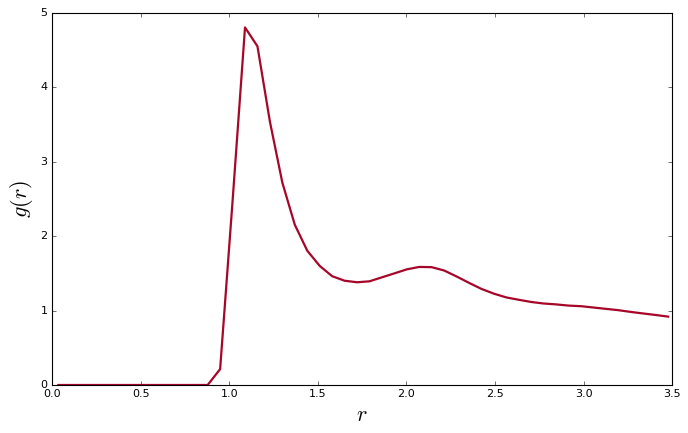

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig1 = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
fig1.set_tight_layout(False)
plt.plot(r, avg_rdf,'-', color="#A60628", linewidth=2, alpha=1)

plt.xlabel('$r$',fontsize=20)
plt.ylabel('$g(r)$',fontsize=20)
plt.show()

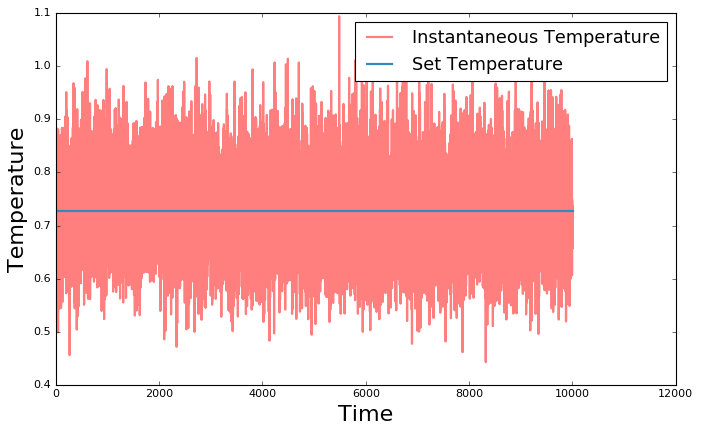

In [15]:
fig2 = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
fig2.set_tight_layout(False)
plt.plot(time, instantaneous_temperature,'-', color="red", linewidth=2, alpha=0.5, label='Instantaneous Temperature')
plt.plot([min(time),max(time)], [temperature]*2,'-', color="#348ABD", linewidth=2, alpha=1, label='Set Temperature')
plt.xlabel('Time',fontsize=20)
plt.ylabel('Temperature',fontsize=20)
plt.legend(fontsize=16,loc=0)
plt.show()

Since the ensemble average $\langle E_\text{kin}\rangle=3/2 N k_B T$ is related to the temperature we may compute the actual temperature in the system via $k_B T= 2/(3N) \langle E_\text{kin}\rangle$. The temperature is fixed and does not fluctuate in the NVT ensemble! The instantaneous temperature is calculated via $ 2/(3N) E_\text{kin}$ (without ensemble averaging) and is not the temperature of the system.

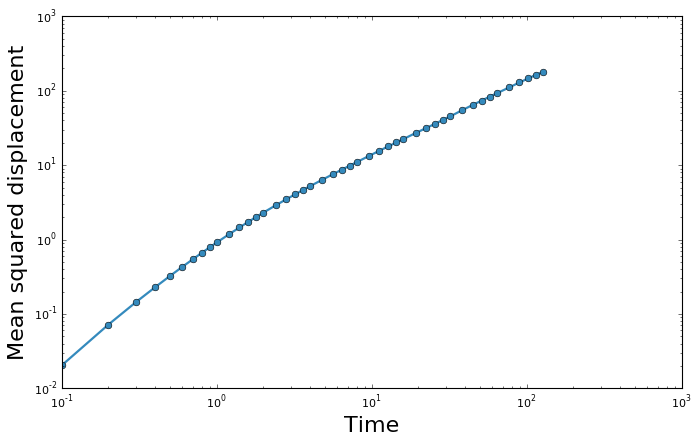

In [18]:
fig3 = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
fig3.set_tight_layout(False)
plt.plot(msd[:,0], msd[:,2]+msd[:,3]+msd[:,4],'o-', color="#348ABD", linewidth=2, alpha=1)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Mean squared displacement',fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.show()

### Simple Error Estimation on Time Series Data

A simple way to estimate the error of an observable is to use the standard error of the mean (SE) for $N$
_uncorrelated_ samples:
\begin{equation}
    SE      = \sqrt{\frac{\sigma}{N}},
\end{equation}
where $\sigma$ is the standard deviation
\begin{equation}
    \sigma  = \langle x^2 - \langle x\rangle^2 \rangle \\
\end{equation}

In [17]:
# calculate the standard error of the mean of the total energy
standard_error_total_energy=np.sqrt(etotal.var())/np.sqrt(sampling_iterations)
print(standard_error_total_energy)

0.130136662219


## Exercises

### Binary Lennard-Jones Liquid

A two-component Lennard Jones liquid can be simulated by placing particles of two types (0 and 1) into the system. Depending on the Lennard-Jones parameters, the two components either mix or separate.

1. Modify the code such that half of the particles are of <tt>type=1</tt>. Type 0 is implied for the remaining particles.
2. Specify Lennard-Jones interactions between type 0 particles with other type 0 particles, type 1 particles with other type 1 particles, and type 0 particles with type 1 particles (set parameters for <tt>system.non_bonded_inter[i,j].lennard_jones</tt> where <tt>{i,j}</tt> can be <tt>{0,0}</tt>, <tt>{1,1}</tt>, and <tt>{0,1}</tt>. Use the same Lennard-Jones parameters for interactions within a component, but use a different <tt>lj_cut_mixed</tt> parameter for the cutoff of the Lennard-Jones interaction between particles of type 0 and particles of type 1. Set this parameter to $2^{\frac16}\sigma$ to get de-mixing or to $2.5\sigma$ to get mixing between the two components.
3. Record the radial distribution functions separately for particles of type 0 around particles of type 0, type 1 around particles of type 1, and type 0 around particles of type 1. This can be done by changing the <tt>type_list</tt> arguments of the <tt>system.analysis.rdf()</tt> command. You can record all three radial distribution functions in a single simulation. It is also possible to write them as several columns into a single file.
4. Plot the radial distribution functions for all three combinations of particle types. The mixed case will differ significantly, depending on your choice of <tt>lj_cut_mixed</tt>. Explain these differences.

## References

[1] <a href="http://espressomd.org">http://espressomd.org</a>

[2] HJ Limbach, A. Arnold, and B. Mann. ESPResSo; an extensible simulation package for research on soft matter systems. Computer Physics Communications, 174(9):704–727, 2006.

[3]  A. Arnold, O. Lenz, S.  Kesselheim, R. Weeber, F. Fahrenberger, D. Rohm, P. Kosovan, and C. Holm. ESPResSo 3.1 — molecular dynamics software for coarse-grained  models. In  M. Griebel  and  M. A. Schweitzer,  editors, Meshfree  Methods for Partial Differential Equations VI, volume 89 of Lecture Notes in Computational Science and Engineering, pages 1–23. Springer Berlin Heidelberg, 2013.

[4]  A. Arnold, BA Mann, HJ Limbach, and C. Holm. ESPResSo–An Extensible Simulation Package for Research on Soft Matter Systems. Forschung und wissenschaftliches Rechnen, 63:43–59, 2003.